<a href="https://colab.research.google.com/github/tmpereira/RGB_spectroscopy/blob/main/29-03-21_calibra%C3%A7ao_PLS_R%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# referencias 

https://blog.francium.tech/using-machine-learning-for-color-calibration-with-a-color-checker-d9f0895eafdb

literatura

https://www.sciencedirect.com/science/article/abs/pii/S2352648317300302



# Importando as bibliotecas e github 


In [1]:
import skimage.io as si
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.transform import rescale, resize, downscale_local_mean
import cv2
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression


!git clone https://github.com/tmpereira/RGB_spectroscopy.git

Cloning into 'RGB_spectroscopy'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 23 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (23/23), done.


importando o jpg contendo o color target


[255 255 255]


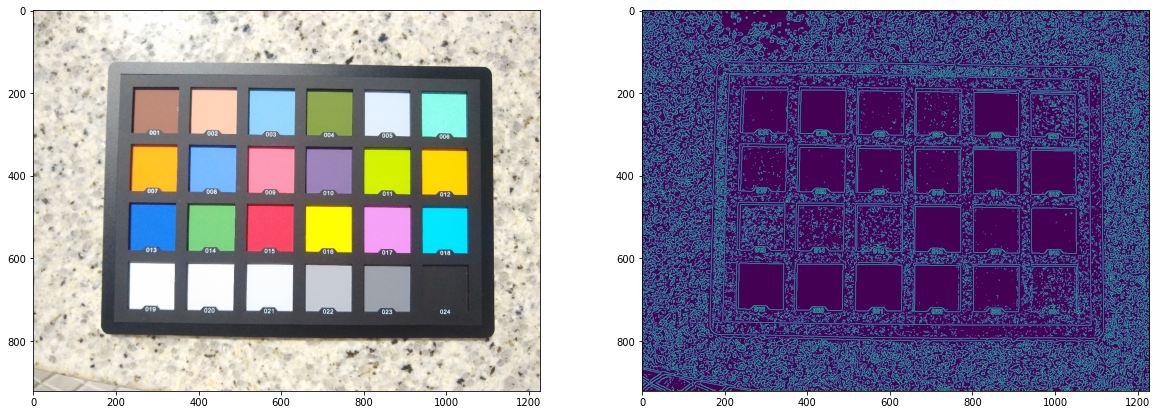

In [2]:
arq = '/content/RGB_spectroscopy/sol.jpg'
img = si.imread(arq)
imgf = img

# pegando os valores maximos de RGB para normalização depois
maxx = img.reshape(-1,3).max(0)
print(maxx)
# reduzindo a imagem para facilitar o recorte dos quadrinhos
f = 0.3
dim = (int(f*img.shape[1]),int(f*img.shape[0]))
img=cv2.resize(img,dim)

# pré processamento para encontrar a borda dos quadrados 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
Blur=cv2.GaussianBlur(gray,(9,9),1) #apply blur to roi
Canny=cv2.Canny(Blur,10,10) #apply canny to roi

# vizualizaçao da imagem  inicial e após pré processamento
plt.figure(figsize=(20,15))
plt.subplot(121)
plt.imshow(img)

plt.subplot(122)
plt.imshow(Canny)

#encontrando os quadrados usando cv2


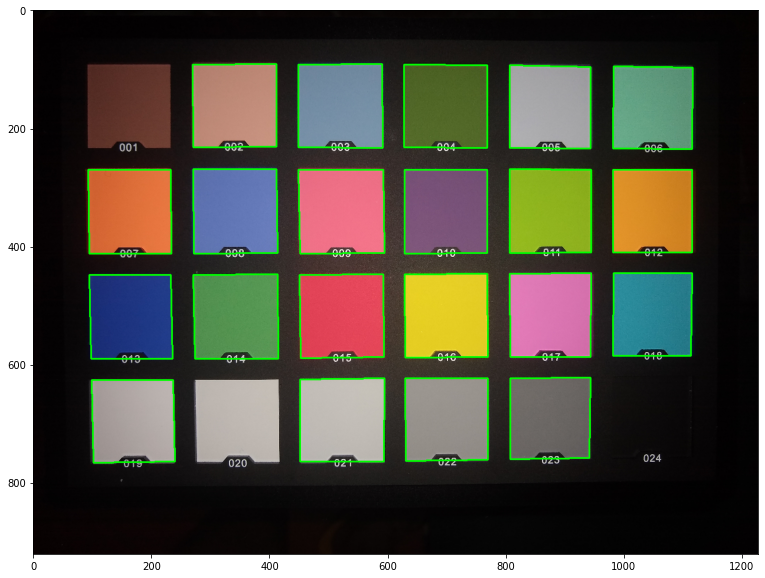

In [ ]:
contours =cv2.findContours(Canny,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)[0]
img2 = img.copy()
cntrRect = []
area = []
for i in contours:
        area.append(cv2.contourArea(i))
        epsilon = 0.05*cv2.arcLength(i,True)
        approx = cv2.approxPolyDP(i,epsilon,True)
        if  cv2.contourArea(i) > 8000:
               cv2.drawContours(img2,cntrRect,-1,(0,255,0),2)
               cntrRect.append(approx)
plt.figure(figsize=(15,10))
plt.imshow(img2)
area = np.sort(area)[::-1]

## recortando os quadrados e plotando separadamente

[19 22 21 23 13 15 14 17 16 18 12 11 10  9  7  8  6  5  4  3  2  1]


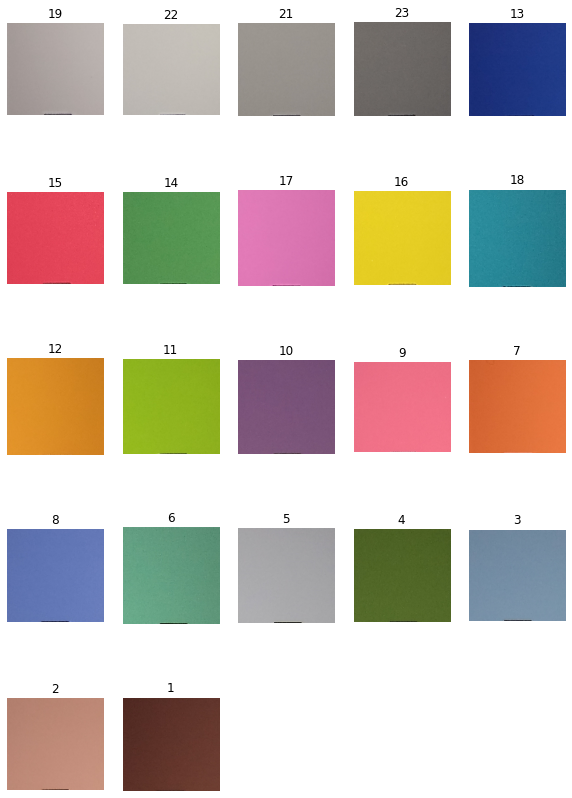

In [ ]:

recortes =[] 
labels =np.array([1,2,3,4,5,6,8,7,9,10,11,12,18,16,17,14,15,13,23,21,22,19])
labels = labels[::-1]
print(labels)
ii = 0
for i in range(len(cntrRect)):     
    rect = cntrRect[i].reshape(4,-1)
    a = rect[:,1].min()+5
    b = rect[:,1].max()-10
    c = rect[:,0].min()+5
    d = rect[:,0].max()-5
    imgsel = img[a:b,c:d]
    recortes.append(imgsel)

# plotando as imagens recortados com seus respectivos numeros
plt.figure(figsize = (10,15))

for i,imgg in enumerate(recortes):
  plt.subplot(5,5,i+1)
  plt.imshow(imgg)
  plt.axis('off')
  plt.title(labels[i])

# Extraindo os RGBs de cada recorte

In [ ]:
RGBmean = [] #np.zeros((labels.shape[0]+1,4))
print(labels)

for i,j in enumerate(recortes):
  RGBmean.append(np.hstack((labels[i],j.reshape(-1,3).mean(0))))
RGBmean = np.array(RGBmean)
#RGBmean[:,1:] = RGBmean[:,1:]# /RGBmean[0,1:].sum(0)
Y = 0.2126*RGBmean[:,1] + 0.7152*RGBmean[:,2] + 0.0722*RGBmean[:,3]

#print(np.column_stack((RGBmean,Y)))
RGBmean[:,1:] = RGBmean[:,1:] # / Y.reshape(-1,1)
print(RGBmean)



[19 22 21 23 13 15 14 17 16 18 12 11 10  9  7  8  6  5  4  3  2  1]
[[ 19.         172.94180153 163.9658626  161.48433588]
 [ 22.         193.09702828 188.29920038 182.17287266]
 [ 21.         150.64726154 145.67015385 140.10036923]
 [ 23.         107.05613628 102.64795457  99.62020906]
 [ 13.          29.94091483  52.75338102 128.42681974]
 [ 15.         227.62559943  69.00704517  88.65295128]
 [ 14.          84.77238806 148.21851679  81.7526236 ]
 [ 17.         219.7062623  118.1113435  178.35014764]
 [ 16.         230.09226423 206.08372904  36.19011841]
 [ 18.          40.57180645 131.95993548 147.78690323]
 [ 12.         215.43587097 137.78167742  36.54277419]
 [ 11.         143.00492126 179.56908219  30.03407972]
 [ 10.         121.4978195   82.87195639 120.4533616 ]
 [  9.         239.63628995 112.97278833 135.35160954]
 [  7.         221.48915069 109.73745267  57.2226964 ]
 [  8.          97.79411419 118.44067199 181.05257284]
 [  6.          97.028032   156.814144   127.48512  

## importando os espectros de absorbancia de HB e HBO2

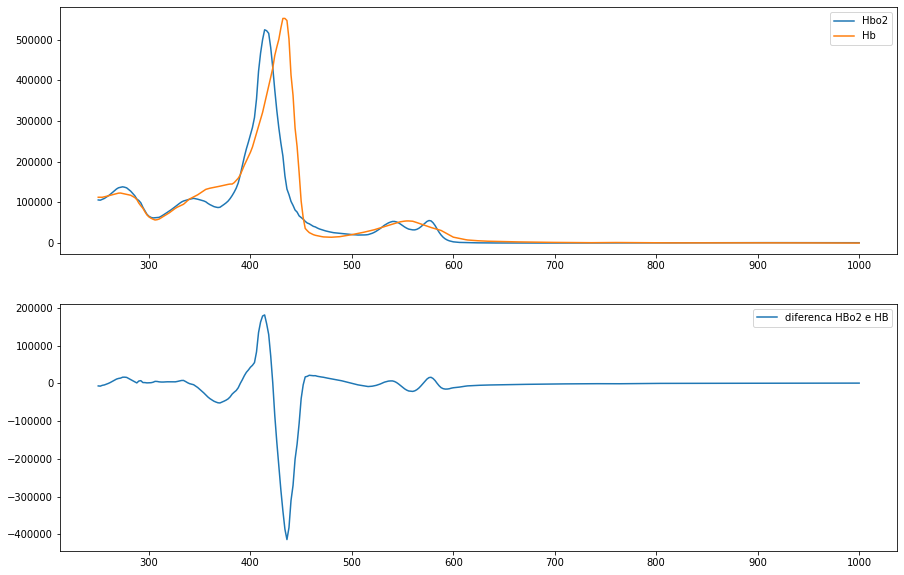

In [ ]:
hb = np.loadtxt('/content/RGB_spectroscopy/prop_Hb.txt',delimiter=';',skiprows=1)
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(hb[:,0],hb[:,1],hb[:,0],hb[:,2])
plt.legend(['Hbo2','Hb'])
plt.subplot(212)
plt.plot(hb[:,0],hb[:,1]-hb[:,2])
plt.legend(['diferenca HBo2 e HB'])

# importando os espectros de referencia do colortarget e plotando eles


[540. 570. 580.]


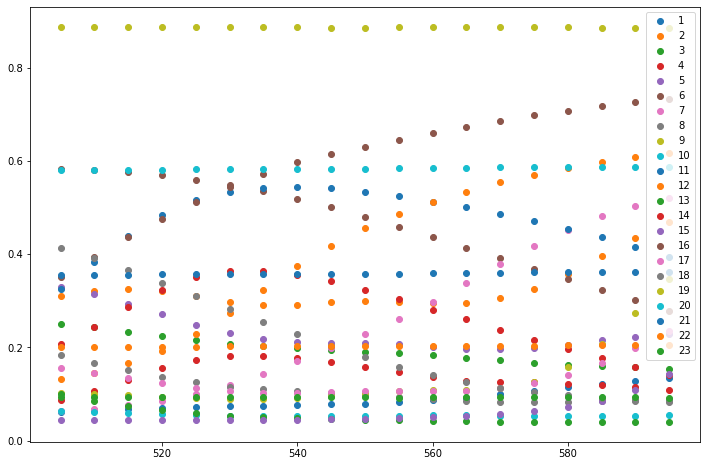

In [ ]:
#importando os dados 
mac_data = np.loadtxt('/content/RGB_spectroscopy/MacbethColorChecker_data.csv',delimiter=';')
mac_data = mac_data [::1,:]
#separando a planilha em lambda(wn) e reflectancia (abss)
wn = mac_data[:,0]
indexlamb = [32,38,40]
print(wn[indexlamb])
abss =mac_data[:,1:]

'''
# restriçao de região espectral
sel = (wn > 500) & (wn < 600)
wn = wn[sel]
abss = abss[sel,:]
'''
# inicializando plotando os resultados 
legenda = []
plt.figure(figsize=(12,8))
for i in range(23):
    plt.scatter(wn,abss[:,i])
    legenda.append(str(i+1))
plt.legend(legenda)

## fazendo o PCA dos espectros 

In [ ]:
npca = 3
pca = PCA(n_components=npca)
pca.fit(abss.T)

components = pca.components_

for i in range(components.shape[0]):
  plt.plot(wn,components[i,:])

# calculando os scores 
scores = pca.transform(abss.T)

# reorganizando os scores com RGBmean
scores_sel =scores[labels-1,:]
print(scores_sel)
print('========================')



## recuperando o espectro de reflectancia usando PLS-R

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.562741491061233

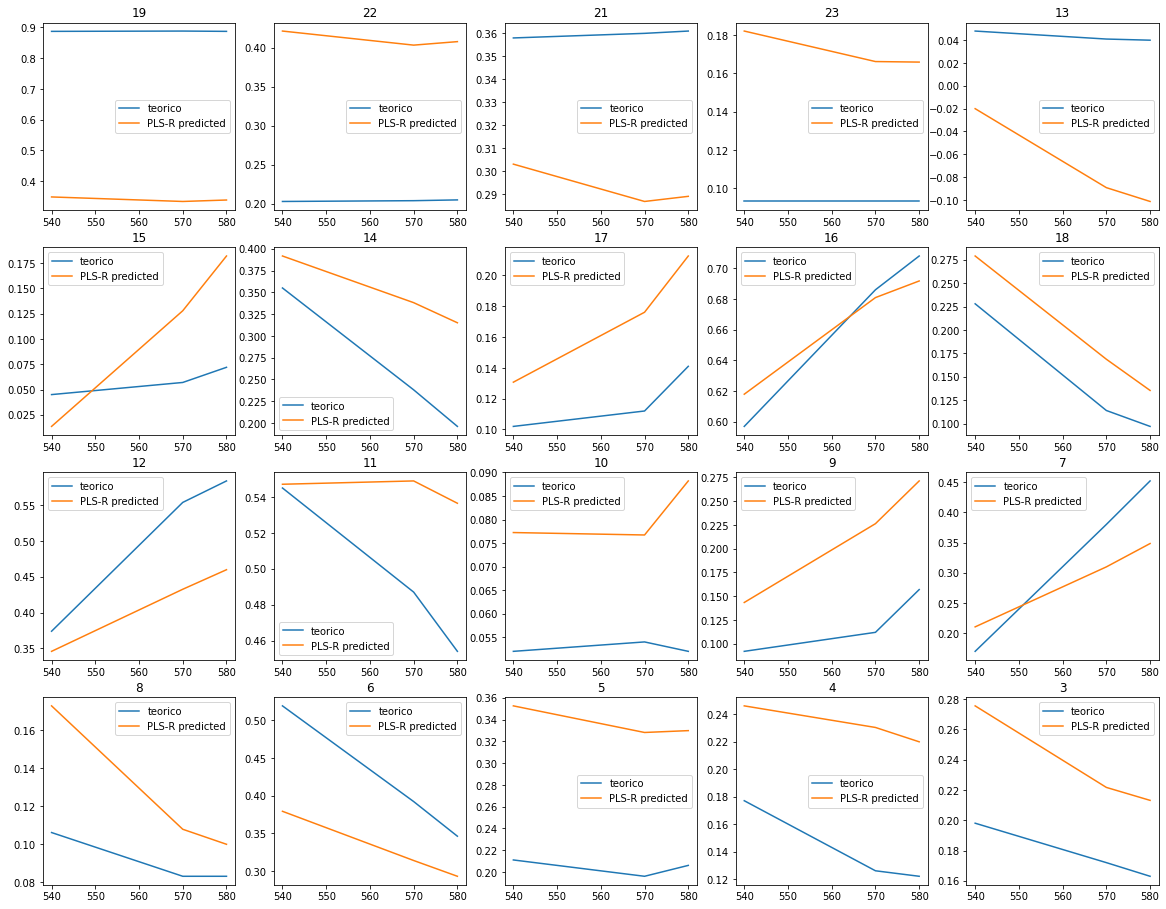

In [ ]:
labels =np.array([1,2,3,4,5,6,8,7,9,10,11,12,18,16,17,14,15,13,23,21,22,19])
labels = labels[::-1]
Y = abss[:,labels-1].T
X = RGBmean[:,1::]
# calculando PLSR
pls2 = PLSRegression(n_components=3)
pls2.fit(X, Y)
Y_pred = pls2.predict(X)
plt.figure(figsize=(20,20))
for k in range(20):
  plt.subplot(5,5,k+1)
  plt.plot(wn,Y[k,:],wn,Y_pred[k,:])
  plt.title(labels[k])
  plt.legend(['teorico', 'PLS-R predicted'])
pls2.score(X,Y)



## convertendo RGB para XYZ usando regressão multipla

[referencia xyY -> XYZ](http://www.brucelindbloom.com/index.html?Eqn_xyY_to_XYZ.html)

soma dos residuos é [3986.83503113 4246.39602319 5589.49727213]


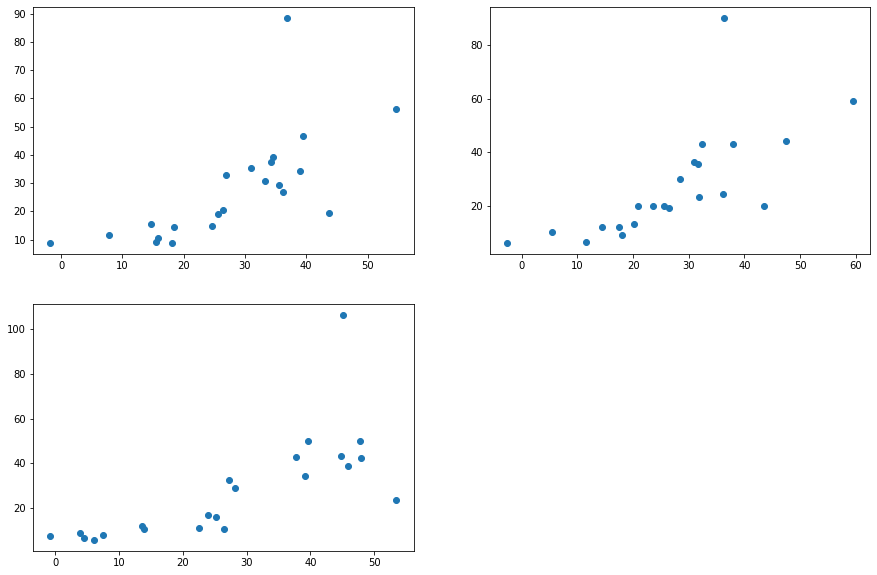

In [ ]:
xyY = np.loadtxt('/content/RGB_spectroscopy/xyY_macbeth.txt',delimiter=';',skiprows=1)
xyY = xyY[:,1::]
x = xyY[:,0]
y = xyY[:,1]
Y = xyY[:,2]
# criando a matriz XYZ
XYZ = np.zeros_like(xyY)
XYZ[:,0] = x*Y/y
XYZ[:,1] = Y
XYZ[:,2] =  ((1-x-y)*Y)/y

# fazendo o PLS-R

Y = XYZ[labels-1,:]
X = RGBmean
X[:,0] = 1

# calculando regressão multipla
XX = np.linalg.lstsq(X, Y, rcond=-1)
print('soma dos residuos é ' + str(XX[1]))
XX = XX[0]
res = X@XX

plt.figure(figsize=(15,10))
plt.subplot(221)
plt.scatter(res[:,0],Y[:,0])


plt.subplot(222)
plt.scatter(res[:,1],Y[:,1])


plt.subplot(223)
plt.scatter(res[:,2],Y[:,2])